In [ ]:
#!pip install opencv-python
!pip3 install trainer
!pip3 install torchvision

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import scipy

In [4]:
from keras import layers
from keras import models
from keras import utils
from keras import regularizers
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets
from keras.layers import InputLayer
from scipy.optimize import minimize
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import History

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

from keras import losses
from sklearn.utils import shuffle

In [5]:
#!/usr/bin/env python3

"""Load image files and labels

This file contains the method that creates data and labels from a directory.
"""
import os
from pathlib import Path

import numpy as np
import cv2

def create_data_with_labels(dataset_dir):
    """Gets numpy data and label array from images that are in the folders
    that are in the folder which was given as a parameter. The folders
    that are in that folder are identified by the beers they represent and
    the folder name starts with the label.

    Parameters:
        dataset_dir: A string specifying the directory of a dataset
    Returns:
        data: A numpy array containing the images
        labels: A numpy array containing labels corresponding to the images
    """
    image_paths_per_label = collect_paths_to_files(dataset_dir)

    images = []
    labels = []
    for label, image_paths in image_paths_per_label.items():
        for image_path in image_paths:
            img = cv2.imread(str(image_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(label)

    data = np.array([preprocess_image(image.astype(np.float32))
                     for image in images])
    labels = np.array(labels)

    return data, labels

def collect_paths_to_files(dataset_dir):
    """Returns a dict with labels for each subdirectory of the given directory
    as keys and lists of the subdirectory's contents as values.

    Parameters:
        dataset_dir: A string containing the path to a directory containing
            subdirectories to different classes.
    Returns:
        image_paths_per_label: A dict with labels as keys and lists of file
        paths as values.
    """
    dataset_dir = Path(dataset_dir)
    beer_dirs = [f for f in sorted(os.listdir(dataset_dir)) if not f.startswith('.')]
    image_paths_per_label = {
        label: [
            dataset_dir / beer_dir / '{0}'.format(f)
            for f in os.listdir(dataset_dir / beer_dir) if not f.startswith('.')
        ]
        for label, beer_dir in enumerate(beer_dirs)
    }
    return image_paths_per_label

def preprocess_image(image):
    """Returns a preprocessed image.

    Parameters:
        image: A RGB image with pixel values in range [0, 255].
    Returns
        image: The preprocessed image.
    """
    image = image / 255.

    return image


In [7]:
(train_data, train_labels) = create_data_with_labels("train")
(eval_data, eval_labels) = create_data_with_labels("eval")

In [8]:
img_shape = train_data.shape[1:]
input_layer = tf.keras.Input(shape=img_shape, name='input_image')

In [9]:
#!/usr/bin/env python3

"""Model to classify draft beers

This file contains all the model information: the training steps, the batch
size and the model itself.
"""

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def get_batch_size():
    """Returns the batch size that will be used by your solution.
    It is recommended to change this value.
    """
    
    # The batch size can be understood as a trade-off between accuracy and speed. Large batch sizes can lead to faster training times but may result in lower accuracy and overfitting, while smaller batch sizes can provide better accuracy, but can be computationally expensive and time-consuming
    return 8

def get_epochs():
    """Returns number of epochs that will be used by your solution.
    It is recommended to change this value.
    """
    return 50

def solution(activation_function='relu',optimizer='rmsprop', init='uniform', loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)):
    """Returns a compiled model.

    This function is expected to return a model to identity the different beers.
    The input layer specifies the shape of the images.
    """ 
    
    # TODO: Code of your solution

    img_shape = train_data.shape[1:]
    input_layer = tf.keras.Input(shape=img_shape, name='input_image')
    # Initialize model
    model = Sequential()
    model.add(input_layer)

    # First group op convolutional layers
    model.add(tf.keras.layers.Conv2D(64, (5,5), padding = "same", activation = 'relu', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(8, 8), strides=2, padding = 'same'))
    model.add(tf.keras.layers.Conv2D(64, (5,5), padding = "same", activation = 'relu', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(8, 8), strides=2, padding = 'same'))

    # Second group of convolutional layers
    model.add(tf.keras.layers.Conv2D(128, (3,3), padding = "same", activation = 'relu', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(8, 8), strides=2, padding = 'same'))
    model.add(tf.keras.layers.Conv2D(128, (3,3), padding = "same", activation = 'relu', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(8, 8), strides=2, padding = 'same'))

    # People usually add two hidden fully connected layers after convolutional layers and before the output layer. 
    # The reason is that convolutional layers try to extract features in a differentiable manner, 
    #  and fully connected layers try to classify the features. Consequently, 
    #  adding more layers to the dense section can empower your network's ability to classify the extracted features better.
    # Dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation = 'relu')) 
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(512, activation = 'relu')) 
    model.add(tf.keras.layers.Dropout(0.5))

    # Output layer
    model.add(tf.keras.layers.Dense(5, activation = 'softmax'))
    model.summary()

    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.0001,
      decay_steps=500//get_batch_size()*10,
      decay_rate=0.9,
      staircase=False)
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay = 0.0001), loss=loss_function, metrics=["accuracy"])
    return model


In [10]:
ml_model = solution()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = ml_model.fit(train_data, train_labels,
             validation_data = (eval_data, eval_labels),
             batch_size=get_batch_size(),
             callbacks=[early_stopping],
             epochs=get_epochs())
ml_model.evaluate(eval_data, eval_labels, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,964,357 (53.27 MB)

 Trainable params: 13,964,357 (53.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 330ms/step - accuracy: 0.2036 - loss: 4.0413 - val_accuracy: 0.2160 - val_loss: 1.6399
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.1975 - loss: 1.6396 - val_accuracy: 0.2720 - val_loss: 1.5917
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - accuracy: 0.2618 - loss: 1.6095 - val_accuracy: 0.2400 - val_loss: 1.5880
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 360ms/step - accuracy: 0.2728 - loss: 1.5665 - val_accuracy: 0.2400 - val_loss: 1.5927
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.2682 - loss: 1.5531 - val_accuracy: 0.4400 - val_loss: 1.5023
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 375ms/step - accuracy: 0.3376 - loss: 1.5090 - val_accuracy: 0.5440 - val_loss: 1.2928
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - accuracy: 0.4150 - loss: 1.3808 - val_accuracy: 0.5040 - val_loss: 1.1818
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 393ms/step - accuracy: 0.5253 - loss: 1.2074 - val_accu

[0.4182553291320801, 0.8880000114440918]

In [ ]:
#save the model (this steps makes it so that you can comment out above steps)
ml_model.save('best_model.keras')

Test loss: 0.4182553291320801
Test accuracy: 0.8880000114440918


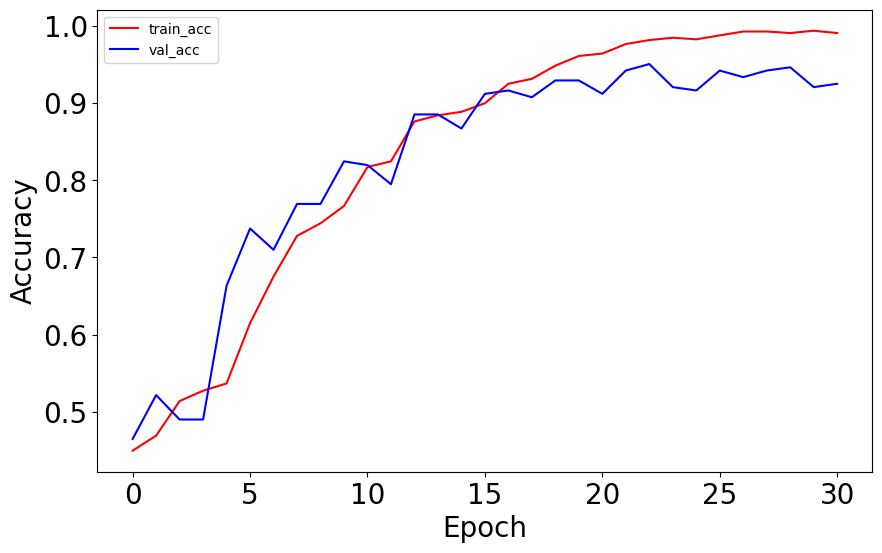

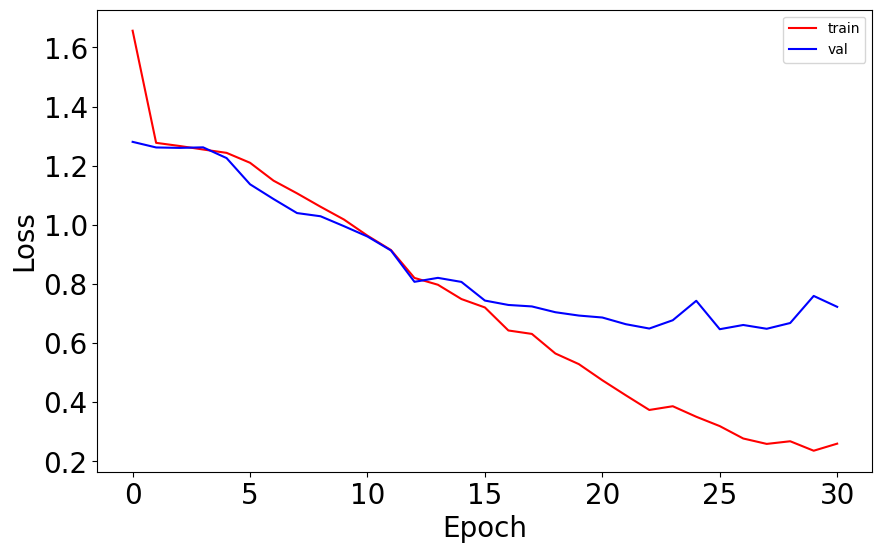

In [12]:
score = ml_model.evaluate(eval_data, eval_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train_acc')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val_acc')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)